In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error

In [13]:
# データの読み込み
df = pd.read_csv('../data/raw_data/train.csv', parse_dates=['datetime'])

# 'datetime'列をdatetime型に変換
df['datetime'] = pd.to_datetime(df['datetime'])

# 指定位置に年，月、日，時間の列を挿入
df.insert(1, 'year', df['datetime'].dt.year)
df.insert(2, 'month', df['datetime'].dt.month)
df.insert(3, 'day', df['datetime'].dt.day)
df.insert(4, 'hour', df['datetime'].dt.hour)

# 結果を表示
df

,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,2011,1,1,2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,2011,1,1,3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,2011,1,1,4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,2012,12,19,19,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,2012,12,19,20,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,2012,12,19,21,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,2012,12,19,22,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [14]:
# (holiday = 0 または workingday = 1) かつ (hourが6~10，17~21) のとき，"peak"に1を追加

df.insert(13, 'peak', (
    ((df['workingday'] == 1) | (df['holiday'] == 0)) & 
    ((df['hour'] >= 6) & (df['hour'] <= 10) | (df['hour'] >= 17) & (df['hour'] <= 21))
).astype(int))

df

,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,peak,casual,registered,count
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0000,0,3,13,16
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0000,0,8,32,40
2,2011-01-01 02:00:00,2011,1,1,2,1,0,0,1,9.02,13.635,80,0.0000,0,5,27,32
3,2011-01-01 03:00:00,2011,1,1,3,1,0,0,1,9.84,14.395,75,0.0000,0,3,10,13
4,2011-01-01 04:00:00,2011,1,1,4,1,0,0,1,9.84,14.395,75,0.0000,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,2012,12,19,19,4,0,1,1,15.58,19.695,50,26.0027,1,7,329,336
10882,2012-12-19 20:00:00,2012,12,19,20,4,0,1,1,14.76,17.425,57,15.0013,1,10,231,241
10883,2012-12-19 21:00:00,2012,12,19,21,4,0,1,1,13.94,15.910,61,15.0013,1,4,164,168
10884,2012-12-19 22:00:00,2012,12,19,22,4,0,1,1,13.94,17.425,61,6.0032,0,12,117,129


In [15]:
# 現在の列インデックスを取得
weather_col_index = df.columns.get_loc("weather")

# ワンホットエンコーディングの実行
weather_dummies = pd.get_dummies(df['weather'], prefix='weather').astype(int)

# 元の 'weather' 列を削除
df = df.drop('weather', axis=1)

# ワンホットエンコーディングした列を、元の 'weather' 列の位置に挿入
for i, col in enumerate(weather_dummies.columns):
    df.insert(weather_col_index + i, col, weather_dummies[col])

df

,datetime,year,month,day,hour,season,holiday,workingday,weather_1,weather_2,weather_3,weather_4,temp,atemp,humidity,windspeed,peak,casual,registered,count
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,0,0,0,9.84,14.395,81,0.0000,0,3,13,16
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,0,0,0,9.02,13.635,80,0.0000,0,8,32,40
2,2011-01-01 02:00:00,2011,1,1,2,1,0,0,1,0,0,0,9.02,13.635,80,0.0000,0,5,27,32
3,2011-01-01 03:00:00,2011,1,1,3,1,0,0,1,0,0,0,9.84,14.395,75,0.0000,0,3,10,13
4,2011-01-01 04:00:00,2011,1,1,4,1,0,0,1,0,0,0,9.84,14.395,75,0.0000,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,2012,12,19,19,4,0,1,1,0,0,0,15.58,19.695,50,26.0027,1,7,329,336
10882,2012-12-19 20:00:00,2012,12,19,20,4,0,1,1,0,0,0,14.76,17.425,57,15.0013,1,10,231,241
10883,2012-12-19 21:00:00,2012,12,19,21,4,0,1,1,0,0,0,13.94,15.910,61,15.0013,1,4,164,168
10884,2012-12-19 22:00:00,2012,12,19,22,4,0,1,1,0,0,0,13.94,17.425,61,6.0032,0,12,117,129


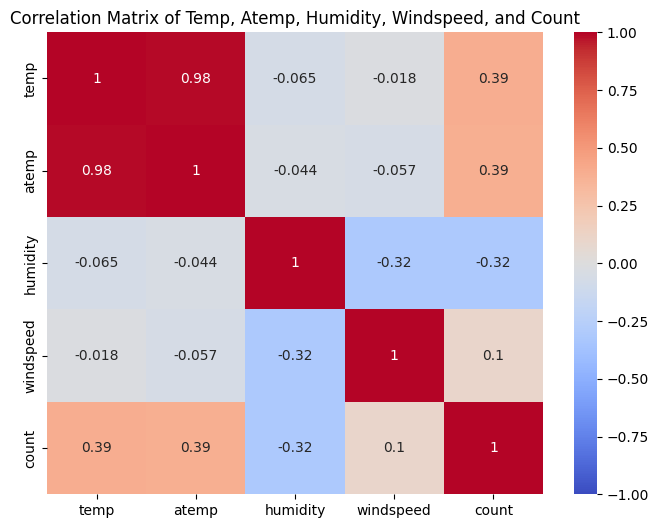

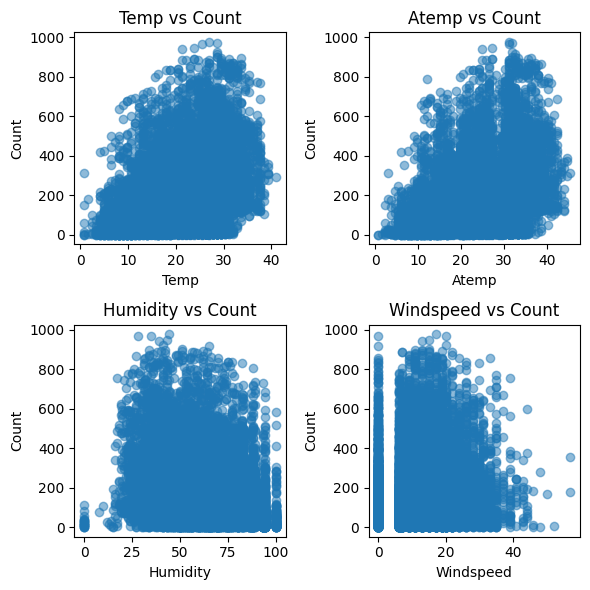

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# temp, atemp, humidity, windspeed, count の相関行列を作成
correlation_matrix = df[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

# 相関行列のヒートマップを作成
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Temp, Atemp, Humidity, Windspeed, and Count')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(6, 6))

# temp vs count
axes[0, 0].scatter(df['temp'], df['count'], alpha=0.5)
axes[0, 0].set_title('Temp vs Count')
axes[0, 0].set_xlabel('Temp')
axes[0, 0].set_ylabel('Count')

# atemp vs count
axes[0, 1].scatter(df['atemp'], df['count'], alpha=0.5)
axes[0, 1].set_title('Atemp vs Count')
axes[0, 1].set_xlabel('Atemp')
axes[0, 1].set_ylabel('Count')

# humidity vs count
axes[1, 0].scatter(df['humidity'], df['count'], alpha=0.5)
axes[1, 0].set_title('Humidity vs Count')
axes[1, 0].set_xlabel('Humidity')
axes[1, 0].set_ylabel('Count')

# windspeed vs count
axes[1, 1].scatter(df['windspeed'], df['count'], alpha=0.5)
axes[1, 1].set_title('Windspeed vs Count')
axes[1, 1].set_xlabel('Windspeed')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()


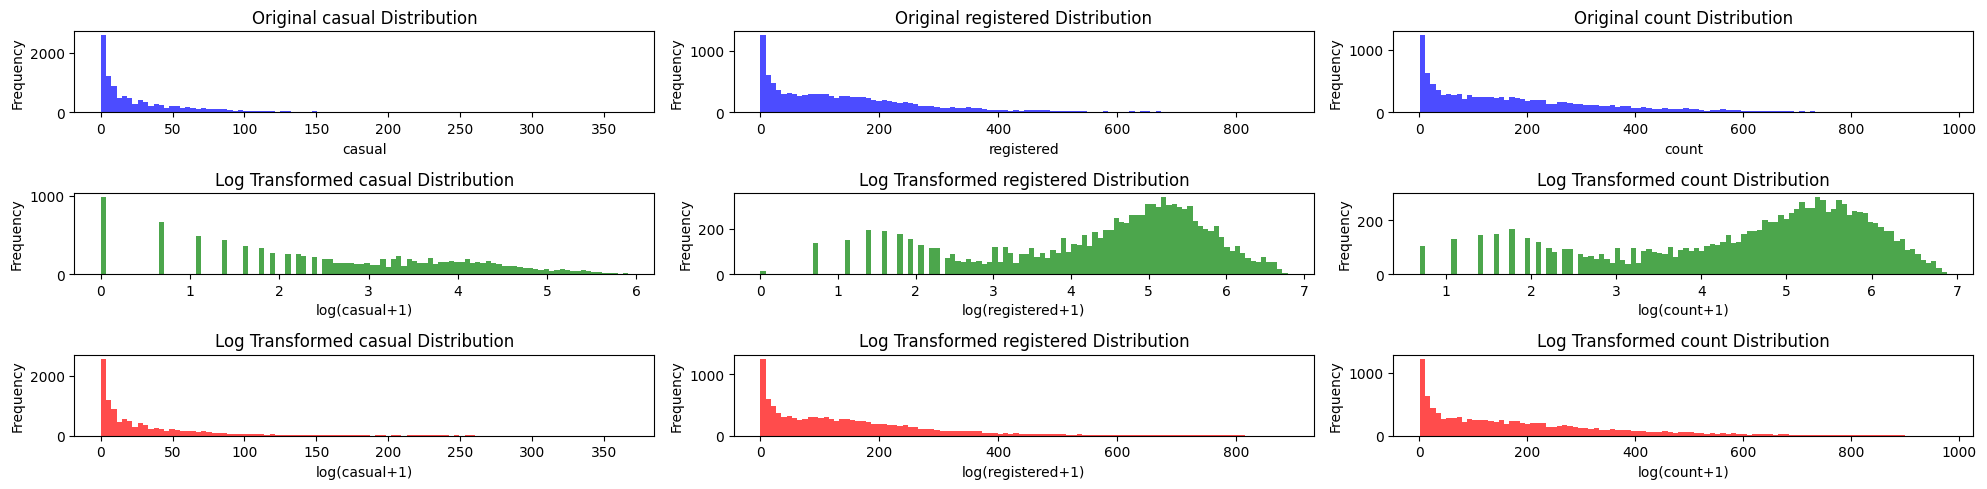

In [17]:
# 元データの分布を確認
fig, axes = plt.subplots(3, 3, figsize=(20, 5))

for i, col in enumerate(['casual', 'registered', 'count']):
    # 元データの分布
    axes[0, i].hist(df[col], bins=100, color='blue', alpha=0.7)
    axes[0, i].set_title(f'Original {col} Distribution')
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel('Frequency')

    # ログ変換したデータの分布
    log_data = np.log1p(df[col])  # log(x+1)変換
    axes[1, i].hist(log_data, bins=100, color='green', alpha=0.7)
    axes[1, i].set_title(f'Log Transformed {col} Distribution')
    axes[1, i].set_xlabel(f'log({col}+1)')
    axes[1, i].set_ylabel('Frequency')

    # もとに戻す操作の確認
    expm_data = np.expm1(log_data)  # exp(x)-1変換
    axes[2, i].hist(expm_data, bins=100, color='red', alpha=0.7)
    axes[2, i].set_title(f'Log Transformed {col} Distribution')
    axes[2, i].set_xlabel(f'log({col}+1)')
    axes[2, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

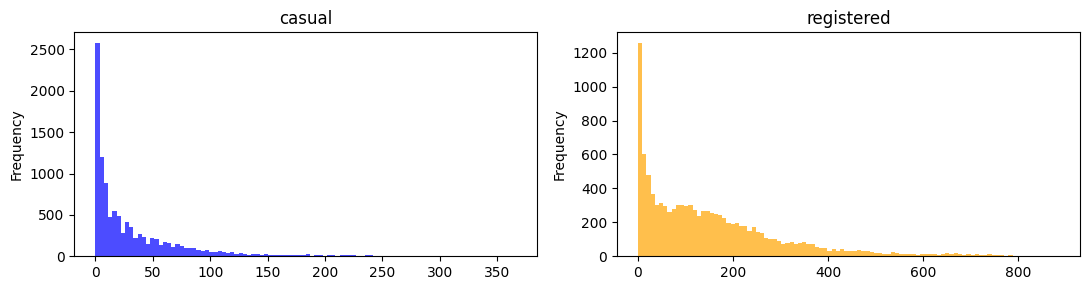

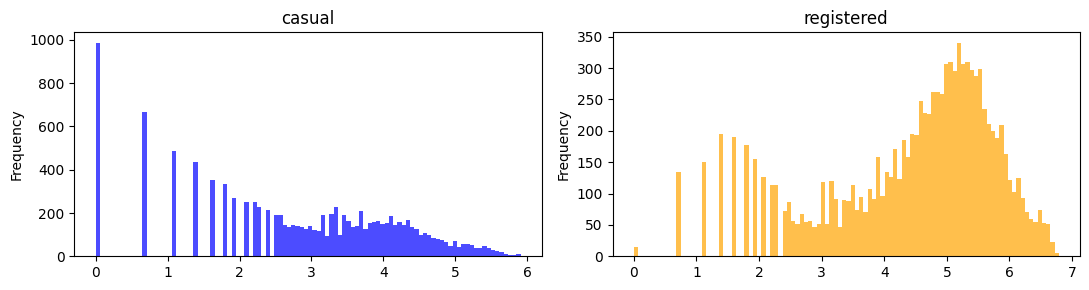

In [28]:
# 横に二つ並べるために 1 行 2 列のレイアウトを指定
fig, axes = plt.subplots(1, 2, figsize=(11, 3))

# casual の分布
axes[0].hist(df['casual'], bins=100, color='blue', alpha=0.7)
axes[0].set_title('casual')
axes[0].set_ylabel('Frequency')

# registered の分布
axes[1].hist(df['registered'], bins=100, color='orange', alpha=0.7)
axes[1].set_title('registered')
axes[1].set_ylabel('Frequency')

# レイアウト調整
plt.tight_layout()
plt.show()


# 横に二つ並べるために 1 行 2 列のレイアウトを指定
fig, axes = plt.subplots(1, 2, figsize=(11, 3))

# casual の分布
log_casual = np.log1p(df['casual'])  # log(x + 1)
axes[0].hist(log_casual, bins=100, color='blue', alpha=0.7)
axes[0].set_title('casual')
axes[0].set_ylabel('Frequency')

# registered の分布
log_registered = np.log1p(df['registered'])  # log(x + 1)
axes[1].hist(log_registered, bins=100, color='orange', alpha=0.7)
axes[1].set_title('registered')
axes[1].set_ylabel('Frequency')

# レイアウト調整
plt.tight_layout()
plt.show()

In [7]:
# casual, registered, count列にログ変換を適用し、新しい列として追加
df['casual_log'] = np.log1p(df['casual'])
df['registered_log'] = np.log1p(df['registered'])
df['count_log'] = np.log1p(df['count'])

df

,datetime,year,month,day,hour,season,holiday,workingday,weather_1,weather_2,...,atemp,humidity,windspeed,peak,casual,registered,count,casual_log,registered_log,count_log
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,0,...,14.395,81,0.0000,0,3,13,16,1.386294,2.639057,2.833213
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,0,...,13.635,80,0.0000,0,8,32,40,2.197225,3.496508,3.713572
2,2011-01-01 02:00:00,2011,1,1,2,1,0,0,1,0,...,13.635,80,0.0000,0,5,27,32,1.791759,3.332205,3.496508
3,2011-01-01 03:00:00,2011,1,1,3,1,0,0,1,0,...,14.395,75,0.0000,0,3,10,13,1.386294,2.397895,2.639057
4,2011-01-01 04:00:00,2011,1,1,4,1,0,0,1,0,...,14.395,75,0.0000,0,0,1,1,0.000000,0.693147,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,2012,12,19,19,4,0,1,1,0,...,19.695,50,26.0027,1,7,329,336,2.079442,5.799093,5.820083
10882,2012-12-19 20:00:00,2012,12,19,20,4,0,1,1,0,...,17.425,57,15.0013,1,10,231,241,2.397895,5.446737,5.488938
10883,2012-12-19 21:00:00,2012,12,19,21,4,0,1,1,0,...,15.910,61,15.0013,1,4,164,168,1.609438,5.105945,5.129899
10884,2012-12-19 22:00:00,2012,12,19,22,4,0,1,1,0,...,17.425,61,6.0032,0,12,117,129,2.564949,4.770685,4.867534


In [55]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
import copy

data = df.copy()

# 入力データとターゲット変数を分割
X = data.drop(columns=["datetime", "day", "atemp", "casual", "registered", "count", "casual_log", "registered_log", "count_log"]) # 不要なカラムの削除

# 正解データ
y_casual = data["casual_log"]
y_registered = data["registered_log"]

# 各モデルのインスタンスとパラメータ設定
models = {
    # "XGBoost":{
    #     "casual": XGBRegressor(
    #         n_estimators=100,           # ブースティングラウンド数
    #         max_depth=100,               # 木の最大深さ
    #         learning_rate=0.1,          # 学習率
    #         objective='reg:squarederror', # 回帰問題のための目的関数
    #         random_state=42
    #     ),
    #     "registered": XGBRegressor(
    #         n_estimators=100,           # ブースティングラウンド数
    #         max_depth=100,               # 木の最大深さ
    #         learning_rate=0.05,          # 学習率
    #         objective='reg:squarederror', # 回帰問題のための目的関数
    #         random_state=42
    #     )
    # },
    "LightGBM":{
        "casual": LGBMRegressor(
            n_estimators=74,          # 多くのツリーを使用し、早期終了で最適なツリー数を決定
            learning_rate=0.05,         # 学習率を下げて、より多くのツリーを利用（過学習防止）
            max_depth=-1,               # 特に制限せずにツリーを成長させる（制限するなら6-10程度）
            num_leaves=130,              # ツリーの複雑さを管理するためのリーフ数
            min_child_samples=6,       # 各リーフに必要な最小データ数（大きいほど規則化が強くなる）
            subsample=0.8,              # バギングのためにサンプルをランダムに抽出する割合（通常0.7-0.9）
            colsample_bytree=0.8,       # 各ツリーで使用する特徴量の割合（通常0.7-0.9）
            reg_alpha=0.1,              # L1正則化（通常0.0-0.1程度でテスト）
            reg_lambda=0.1,             # L2正則化（通常0.0-0.1程度でテスト）
            random_state=42,
            verbosity=-1
        ),
        "registered": LGBMRegressor(
            n_estimators=107,          # 多くのツリーを使用し、早期終了で最適なツリー数を決定
            learning_rate=0.05,         # 学習率を下げて、より多くのツリーを利用（過学習防止）
            max_depth=-1,               # 特に制限せずにツリーを成長させる（制限するなら6-10程度）
            num_leaves=128,              # ツリーの複雑さを管理するためのリーフ数
            min_child_samples=23,       # 各リーフに必要な最小データ数（大きいほど規則化が強くなる）
            subsample=0.8,              # バギングのためにサンプルをランダムに抽出する割合（通常0.7-0.9）
            colsample_bytree=0.8,       # 各ツリーで使用する特徴量の割合（通常0.7-0.9）
            reg_alpha=0.1,              # L1正則化（通常0.0-0.1程度でテスト）
            reg_lambda=0.1,             # L2正則化（通常0.0-0.1程度でテスト）
            random_state=42,
            verbosity=-1
        )
    }
}

# 精度評価関数 (RMSLE)
def evaluate_model_rmsle(y_true, y_pred):
    y_pred = np.where(y_pred < 0, 0, y_pred) # 負の予測値を 0.0 に置き換え
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    return rmsle

# 日付ごとにグループを指定
day_groups = [
    [1, 2, 3, 4],  # グループ1
    [5, 6, 7, 8],  # グループ2
    [9, 10, 11, 12],  # グループ3
    [13, 14, 15, 16],  # グループ4
    [17, 18, 19]   # グループ5
]

In [57]:
# モデルの保存リスト
saved_models = []
validation_indices = []

# dropするデータを指定
drop_columns = ["datetime", "day", "atemp", "casual", "registered", "count", "casual_log", "registered_log", "count_log"]

# casual と registered の予測精度をモデルごとにクロスバリデーションで確認
for model_name, model_group in models.items():
    casual_scores = []
    registered_scores = []
    count_scores = []

    for fold, days in enumerate(day_groups, start=1):
        # 指定された日付のみをテストセットとする
        train_data = data[~data['day'].isin(days)]
        test_data = data[data['day'].isin(days)]

        # 学習データとテストデータを設定
        X_train, X_test = train_data.drop(columns=drop_columns), test_data.drop(columns=drop_columns)
        y_casual_train, y_casual_test = train_data["casual_log"], test_data["casual_log"]
        y_registered_train, y_registered_test = train_data["registered_log"], test_data["registered_log"]

        # casual モデルの学習と評価
        casual_model = copy.deepcopy(model_group["casual"])
        casual_model.fit(X_train, y_casual_train)
        y_casual_pred = casual_model.predict(X_test)
        casual_rmsle = evaluate_model_rmsle(np.expm1(y_casual_test), np.expm1(y_casual_pred))
        casual_scores.append(casual_rmsle)

        # モデルをコピーして保存 (casual モデル)
        saved_models.append({"model_name": f"{model_name}_casual_fold_{fold}", "model": copy.deepcopy(casual_model)})

        # registered モデルの学習と評価
        registered_model = copy.deepcopy(model_group["registered"])
        registered_model.fit(X_train, y_registered_train)
        y_registered_pred = registered_model.predict(X_test)
        registered_rmsle = evaluate_model_rmsle(np.expm1(y_registered_test), np.expm1(y_registered_pred))
        registered_scores.append(registered_rmsle)

        # モデルをコピーして保存 (registered モデル)
        saved_models.append({"model_name": f"{model_name}_registered_fold_{fold}", "model": copy.deepcopy(registered_model)})

        # count の予測精度y_pred = np.round(y_pred).astype(int)
        y_count_pred = np.expm1(y_casual_pred) + np.expm1(y_registered_pred)
        y_count_test = np.expm1(y_casual_test) + np.expm1(y_registered_test)
        count_rmsle = evaluate_model_rmsle(y_count_test, y_count_pred)
        count_scores.append(count_rmsle)

    # 結果表示
    print(f"Model: {model_name}")
    print(f"Casual Prediction - Mean RMSLE: {np.mean(casual_scores):.3f}")
    print(f"Registered Prediction - Mean RMSLE: {np.mean(registered_scores):.3f}")
    print(f"Count Prediction - Mean RMSLE: {np.mean(count_scores):.3f}\n")


# 学習済みモデルリストの内容を表示
for saved_model in saved_models:
    print(f"Saved Model: {saved_model['model_name']}")

Model: LightGBM
Casual Prediction - Mean RMSLE: 0.537
Registered Prediction - Mean RMSLE: 0.342
Count Prediction - Mean RMSLE: 0.344

Saved Model: LightGBM_casual_fold_1
Saved Model: LightGBM_registered_fold_1
Saved Model: LightGBM_casual_fold_2
Saved Model: LightGBM_registered_fold_2
Saved Model: LightGBM_casual_fold_3
Saved Model: LightGBM_registered_fold_3
Saved Model: LightGBM_casual_fold_4
Saved Model: LightGBM_registered_fold_4
Saved Model: LightGBM_casual_fold_5
Saved Model: LightGBM_registered_fold_5


In [58]:
# データの読み込み
df_test = pd.read_csv('../data/raw_data/test.csv', parse_dates=['datetime'])

# 'datetime'列をdatetime型に変換
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

# 指定位置に年、月、日、時間の列を挿入
df_test.insert(1, 'year', df_test['datetime'].dt.year)
df_test.insert(2, 'month', df_test['datetime'].dt.month)
df_test.insert(3, 'day', df_test['datetime'].dt.day)
df_test.insert(4, 'hour', df_test['datetime'].dt.hour)

# (holiday = 0 または workingday = 1) かつ (hourが6~10，17~21) のとき，"peak"に1を追加
df_test.insert(13, 'peak', (
    ((df_test['workingday'] == 1) | (df_test['holiday'] == 0)) & 
    ((df_test['hour'] >= 6) & (df_test['hour'] <= 10) | (df_test['hour'] >= 17) & (df_test['hour'] <= 21))
).astype(int))

# 現在の列インデックスを取得
weather_col_index = df_test.columns.get_loc("weather")

# ワンホットエンコーディングの実行
weather_dummies = pd.get_dummies(df_test['weather'], prefix='weather').astype(int)

# 元の 'weather' 列を削除
df_test = df_test.drop('weather', axis=1)

# ワンホットエンコーディングした列を、元の 'weather' 列の位置に挿入
for i, col in enumerate(weather_dummies.columns):
    df_test.insert(weather_col_index + i, col, weather_dummies[col])

df_test

,datetime,year,month,day,hour,season,holiday,workingday,weather_1,weather_2,weather_3,weather_4,temp,atemp,humidity,windspeed,peak
0,2011-01-20 00:00:00,2011,1,20,0,1,0,1,1,0,0,0,10.66,11.365,56,26.0027,0
1,2011-01-20 01:00:00,2011,1,20,1,1,0,1,1,0,0,0,10.66,13.635,56,0.0000,0
2,2011-01-20 02:00:00,2011,1,20,2,1,0,1,1,0,0,0,10.66,13.635,56,0.0000,0
3,2011-01-20 03:00:00,2011,1,20,3,1,0,1,1,0,0,0,10.66,12.880,56,11.0014,0
4,2011-01-20 04:00:00,2011,1,20,4,1,0,1,1,0,0,0,10.66,12.880,56,11.0014,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,2012,12,31,19,1,0,1,0,1,0,0,10.66,12.880,60,11.0014,1
6489,2012-12-31 20:00:00,2012,12,31,20,1,0,1,0,1,0,0,10.66,12.880,60,11.0014,1
6490,2012-12-31 21:00:00,2012,12,31,21,1,0,1,1,0,0,0,10.66,12.880,60,11.0014,1
6491,2012-12-31 22:00:00,2012,12,31,22,1,0,1,1,0,0,0,10.66,13.635,56,8.9981,0


In [59]:
# dropするデータを指定
drop_columns = ["datetime", "day", "atemp"]

# モデルに使う説明変数を作成
X_test = df_test.drop(columns=drop_columns)

# モデルを指定
#model_name = "XGBoost"
#model_name = "RandomForest"
model_name = "LightGBM"

count_pred_list = []
for fold_num in range(len(day_groups)):
    # それぞれ予測するモデルを作成
    casual_model = next(model['model'] for model in saved_models if model['model_name'] == f"{model_name}_casual_fold_{fold_num+1}")
    registered_model = next(model['model'] for model in saved_models if model['model_name'] == f"{model_name}_registered_fold_{fold_num+1}")

    # テストデータに対する予測
    y_casual_pred = casual_model.predict(X_test)
    y_registered_pred = registered_model.predict(X_test)

    # 予測結果が負になるのを防ぐため、0未満の値を0に置き換え
    y_casual_pred = np.where(y_casual_pred < 0, 0, y_casual_pred)
    y_registered_pred = np.where(y_registered_pred < 0, 0, y_registered_pred)

    # casual と registered の予測を合計して count の予測を計算
    y_count_pred = np.expm1(y_casual_pred) + np.expm1(y_registered_pred)

    # 各foldの予測結果をリストに追加
    count_pred_list.append(y_count_pred)

# 各foldの予測結果を平均して最終予測を作成
y_count_pred_mean = np.mean(count_pred_list, axis=0)

# 結果を 'datetime' と 'count' の形で DataFrame に変換
submission = pd.DataFrame({
    "datetime": df_test["datetime"],
    "count": y_count_pred_mean
})

# 'submission.csv' に保存
submission.to_csv("../out/submission-2.csv", index=False)

print("Done!")

Done!


In [68]:
df

,datetime,year,month,day,hour,season,holiday,workingday,weather_1,weather_2,...,atemp,humidity,windspeed,peak,casual,registered,count,casual_log,registered_log,count_log
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,0,...,14.395,81,0.0000,0,3,13,16,1.386294,2.639057,2.833213
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,0,...,13.635,80,0.0000,0,8,32,40,2.197225,3.496508,3.713572
2,2011-01-01 02:00:00,2011,1,1,2,1,0,0,1,0,...,13.635,80,0.0000,0,5,27,32,1.791759,3.332205,3.496508
3,2011-01-01 03:00:00,2011,1,1,3,1,0,0,1,0,...,14.395,75,0.0000,0,3,10,13,1.386294,2.397895,2.639057
4,2011-01-01 04:00:00,2011,1,1,4,1,0,0,1,0,...,14.395,75,0.0000,0,0,1,1,0.000000,0.693147,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,2012,12,19,19,4,0,1,1,0,...,19.695,50,26.0027,1,7,329,336,2.079442,5.799093,5.820083
10882,2012-12-19 20:00:00,2012,12,19,20,4,0,1,1,0,...,17.425,57,15.0013,1,10,231,241,2.397895,5.446737,5.488938
10883,2012-12-19 21:00:00,2012,12,19,21,4,0,1,1,0,...,15.910,61,15.0013,1,4,164,168,1.609438,5.105945,5.129899
10884,2012-12-19 22:00:00,2012,12,19,22,4,0,1,1,0,...,17.425,61,6.0032,0,12,117,129,2.564949,4.770685,4.867534


In [ ]:
from prophet import Prophet

# データのコピー
df_prophet = df.copy()

# 学習データの前処理
df_train = df_prophet[df_prophet['datetime'].dt.day <= 18]  # 各月の1日から18日をtrainデータ
df_valid = df_prophet[df_prophet['datetime'].dt.day > 18]   # 各月の19日から月末までをvalidデータ

# 説明変数
explain = ['year','month','hour','season','holiday','workingday','temp','atemp','humidity','windspeed','peak','weather_1','weather_2','weather_3','weather_4']

# Prophetのモデル用にデータを整形し、対数変換を適用
df_train_prophet = df_train[['datetime'] + explain + ['casual']].rename(columns={'datetime': 'ds', 'casual': 'y'})
df_train_prophet['y'] = np.log1p(df_train_prophet['y'])  # casual列に対数変換を適用

# Prophet学習設定
model = Prophet()
model.add_seasonality(name='hourly', period=24, fourier_order=10)

# 追加の回帰変数として指定
for i in explain:
    model.add_regressor(i)

# 学習
model.fit(df_train_prophet)

# 検証データ
df_valid_prophet = df_valid[['datetime'] + explain].rename(columns={'datetime': 'ds'})

# 予測
forecast = model.predict(df_valid_prophet)

# 予測結果に対して逆変換を適用
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(0, np.expm1(x)))  # yhat列に対して逆変換を適用し，0以下の場合は0に置換
forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'])  # yhat_lowerにも逆変換を適用
forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'])  # yhat_upperにも逆変換を適用

# 予測結果の確認
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

casualの最大値: 367


17:28:30 - cmdstanpy - INFO - Chain [1] start processing
17:28:33 - cmdstanpy - INFO - Chain [1] done processing


                     ds       yhat  yhat_lower  yhat_upper
569 2012-12-19 19:00:00  21.915144    9.753404   50.939480
570 2012-12-19 20:00:00  15.285687    6.388703   33.889675
571 2012-12-19 21:00:00  10.614714    4.639507   24.309971
572 2012-12-19 22:00:00   8.916626    3.649841   20.607187
573 2012-12-19 23:00:00   7.058347    2.659302   17.220662


In [270]:
target = df_valid[['datetime', 'casual']].copy().reset_index(drop=True).copy()
pred = forecast[['ds', 'yhat']].copy().reset_index(drop=True).copy()

# 実際の値と予測値を datetime でマージ
merged = pd.merge(target[['datetime', 'casual']], pred[['ds', 'yhat']], left_on='datetime', right_on='ds')
y_true = merged['casual']
y_pred = merged['yhat']

# RMSLEの計算
rmsle_score = evaluate_model_rmsle(y_true, y_pred)
print("RMSLE:", rmsle_score)

RMSLE: 0.5360376699595062


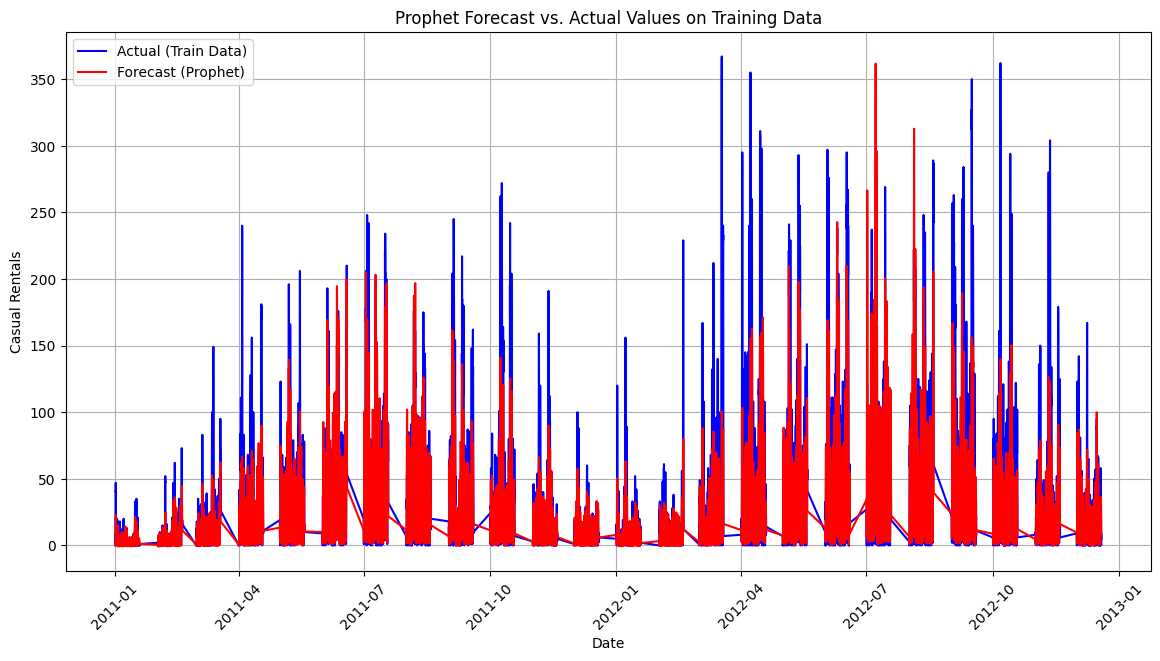

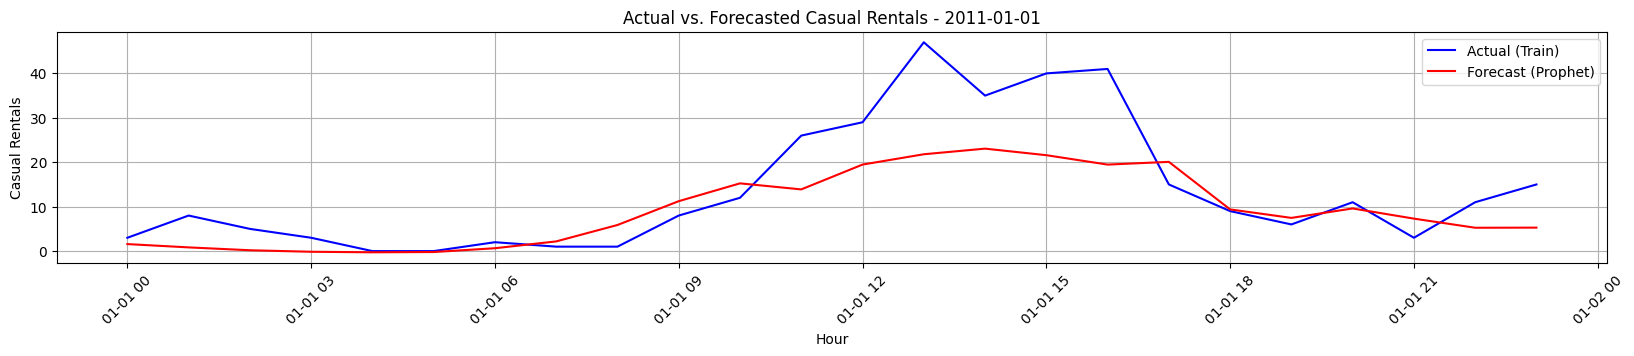

In [244]:
# 学習データに対する予測
forecast_train = model.predict(df_train_prophet)

# 予測結果に対して逆変換を適用
forecast_train['yhat'] = np.expm1(forecast_train['yhat'])
forecast_train['yhat_lower'] = np.expm1(forecast_train['yhat_lower'])
forecast_train['yhat_upper'] = np.expm1(forecast_train['yhat_upper'])

# 実際の値と予測値をプロット
plt.figure(figsize=(14, 7))
plt.plot(df_train['datetime'], df_train['casual'], label="Actual (Train Data)", color="blue")
plt.plot(forecast_train['ds'], forecast_train['yhat'], label="Forecast (Prophet)", color="red")

# グラフの装飾
plt.xlabel("Date")
plt.ylabel("Casual Rentals")
plt.title("Prophet Forecast vs. Actual Values on Training Data")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # 日付ラベルを見やすくするために45度回転
plt.show()

# 学習データの対象日ごとに個別のグラフを出力
for day in df_train['datetime'].dt.date.unique():  # 日ごとのループ
    # 特定の日のデータを抽出
    df_train_day = df_train[df_train['datetime'].dt.date == day]
    df_forecast_train_day = forecast_train[forecast_train['ds'].dt.date == day]

    # プロット
    plt.figure(figsize=(20, 3))
    plt.plot(df_train_day['datetime'], df_train_day['casual'], label="Actual (Train)", color="blue")
    plt.plot(df_forecast_train_day['ds'], df_forecast_train_day['yhat'], label="Forecast (Prophet)", color="red")

    # グラフの装飾
    plt.xlabel("Hour")
    plt.ylabel("Casual Rentals")
    plt.title(f"Actual vs. Forecasted Casual Rentals - {day}")
    plt.legend()
    plt.xticks(rotation=45)  # 時間ラベルを見やすくするために45度回転
    plt.grid(True)
    plt.show()

    break



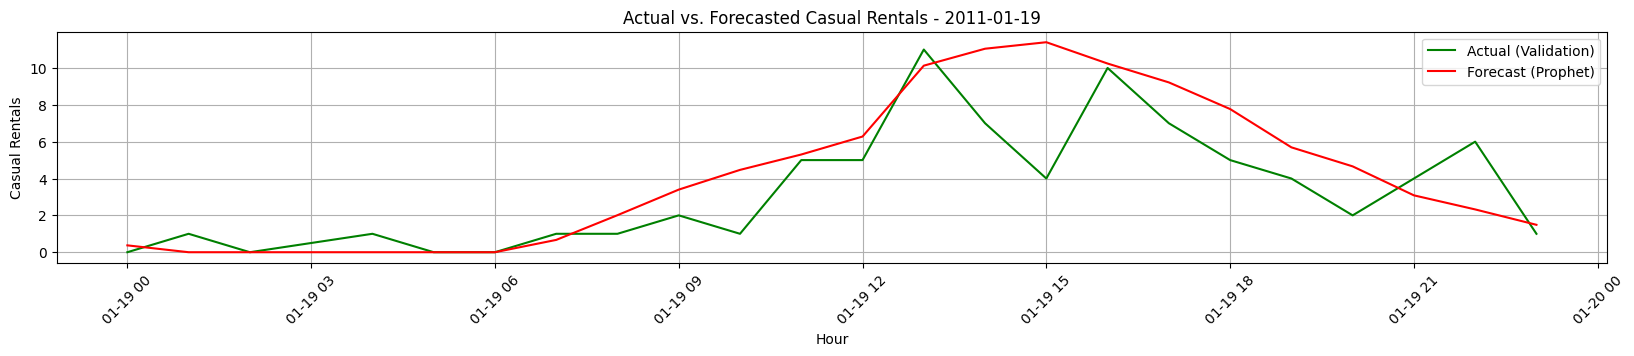

In [246]:
# 検証データの対象日ごとに個別のグラフを出力
for day in df_valid['datetime'].dt.date.unique():  # 日ごとのループ
    # 特定の日のデータを抽出
    df_valid_day = df_valid[df_valid['datetime'].dt.date == day]
    df_forecast_day = forecast[forecast['ds'].dt.date == day]

    # プロット
    plt.figure(figsize=(20, 3))
    plt.plot(df_valid_day['datetime'], df_valid_day['casual'], label="Actual (Validation)", color="green")
    plt.plot(df_forecast_day['ds'], df_forecast_day['yhat'], label="Forecast (Prophet)", color="red")

    # グラフの装飾
    plt.xlabel("Hour")
    plt.ylabel("Casual Rentals")
    plt.title(f"Actual vs. Forecasted Casual Rentals - {day}")
    plt.legend()
    plt.xticks(rotation=45)  # 時間ラベルを見やすくするために45度回転
    plt.grid(True)
    plt.show()

    break

17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:11 - cmdstanpy - INFO - Chain [1] done processing


                     ds        yhat  yhat_lower  yhat_upper
569 2012-12-19 19:00:00  428.129495  198.737502  940.332683
570 2012-12-19 20:00:00  274.047331  125.722340  609.443584
571 2012-12-19 21:00:00  171.419031   81.491673  363.773240
572 2012-12-19 22:00:00  131.382911   61.065160  296.094466
573 2012-12-19 23:00:00  116.559405   54.081838  246.230433
RMSLE: 0.5760663974393425


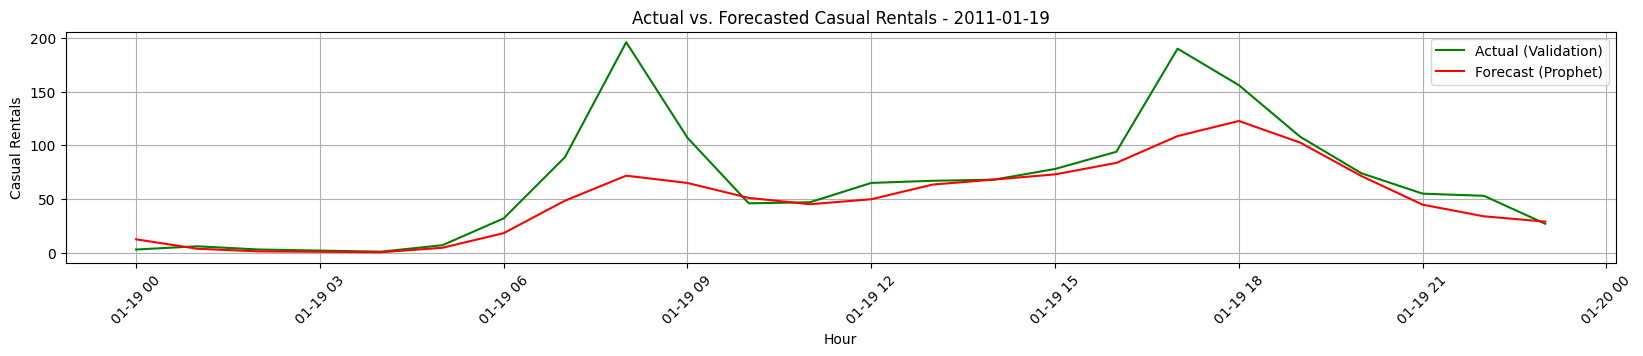

In [275]:
from prophet import Prophet

# データのコピー
df_prophet = df.copy()

# 学習データの前処理
df_train = df_prophet[df_prophet['datetime'].dt.day <= 18]  # 各月の1日から18日をtrainデータ
df_valid = df_prophet[df_prophet['datetime'].dt.day > 18]   # 各月の19日から月末までをvalidデータ

# 説明変数
explain = ['year','month','hour','season','holiday','workingday','temp','atemp','humidity','windspeed','peak','weather_1','weather_2','weather_3','weather_4']

# Prophetのモデル用にデータを整形し、対数変換を適用
df_train_prophet = df_train[['datetime'] + explain + ['registered']].rename(columns={'datetime': 'ds', 'registered': 'y'})
df_train_prophet['y'] = np.log1p(df_train_prophet['y'])  # casual列に対数変換を適用

# Prophet学習設定
model = Prophet()
model.add_seasonality(name='hourly', period=24, fourier_order=10)

# 追加の回帰変数として指定
for i in explain:
    model.add_regressor(i)

# 学習
model.fit(df_train_prophet)

# 検証データ
df_valid_prophet = df_valid[['datetime'] + explain].rename(columns={'datetime': 'ds'})

# 予測
forecast = model.predict(df_valid_prophet)

# 予測結果に対して逆変換を適用
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(0, np.expm1(x)))  # yhat列に対して逆変換を適用し，0以下の場合は0に置換
forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'])  # yhat_lowerにも逆変換を適用
forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'])  # yhat_upperにも逆変換を適用

# 予測結果の確認
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

target = df_valid[['datetime', 'registered']].copy().reset_index(drop=True).copy()
pred = forecast[['ds', 'yhat']].copy().reset_index(drop=True).copy()

# 実際の値と予測値を datetime でマージ
merged = pd.merge(target[['datetime', 'registered']], pred[['ds', 'yhat']], left_on='datetime', right_on='ds')
y_true = merged['registered']
y_pred = merged['yhat']

# RMSLEの計算
rmsle_score = evaluate_model_rmsle(y_true, y_pred)
print("RMSLE:", rmsle_score)

# 検証データの対象日ごとに個別のグラフを出力
for day in df_valid['datetime'].dt.date.unique():  # 日ごとのループ
    # 特定の日のデータを抽出
    df_valid_day = df_valid[df_valid['datetime'].dt.date == day]
    df_forecast_day = forecast[forecast['ds'].dt.date == day]

    # プロット
    plt.figure(figsize=(20, 3))
    plt.plot(df_valid_day['datetime'], df_valid_day['registered'], label="Actual (Validation)", color="green")
    plt.plot(df_forecast_day['ds'], df_forecast_day['yhat'], label="Forecast (Prophet)", color="red")

    # グラフの装飾
    plt.xlabel("Hour")
    plt.ylabel("Casual Rentals")
    plt.title(f"Actual vs. Forecasted Casual Rentals - {day}")
    plt.legend()
    plt.xticks(rotation=45)  # 時間ラベルを見やすくするために45度回転
    plt.grid(True)
    plt.show()

    break

In [239]:
# モデルを保存するためのリスト
saved_models = []

# クロスバリデーションのグループ
day_groups = [
    [1, 6, 11, 16],    # グループ1
    [2, 7, 12, 17],    # グループ2
    [3, 8, 13, 18], # グループ3
    [4, 9, 14, 19],# グループ4
    [5, 10, 15]     # グループ5
]

# 説明変数
explain = ['year','month','hour','season','holiday','workingday','temp','atemp','humidity','windspeed','peak','weather_1','weather_2','weather_3','weather_4']

# クロスバリデーションを実行
for i, group in enumerate(day_groups):
    print("valid month : ", group)
    # 学習データと検証データを分割
    df_train_fold = df_train[~df_train['datetime'].dt.day.isin(group)]
    df_valid_fold = df_train[df_train['datetime'].dt.day.isin(group)]
    
    # Prophetのモデル用にデータを整形し、対数変換を適用
    df_train_prophet = df_train_fold[['datetime'] + explain + ['casual']].rename(columns={'datetime': 'ds', 'casual': 'y'})
    df_train_prophet['y'] = np.log1p(df_train_prophet['y'])
    
    # Prophetモデルのインスタンス作成と学習
    model = Prophet()
    model.add_seasonality(name='hourly', period=24, fourier_order=100)
    
    # 説明変数の追加
    for regressor in explain:
        model.add_regressor(regressor)
        
    # モデルを学習
    model.fit(df_train_prophet)
    
    # モデルを変数として保存
    saved_models.append({"model_name": f"prophet_casual_fold_{i+1}", "model": copy.deepcopy(model)})
    
    print(f"prophet_casual_fold_{i+1} saved")

    # 検証データ
    df_valid_prophet = df_valid[['datetime'] + explain].rename(columns={'datetime': 'ds'})

    # 予測
    forecast = model.predict(df_valid_prophet)

    # 予測結果に対して逆変換を適用
    forecast['yhat'] = forecast['yhat'].apply(lambda x: max(0, np.expm1(x)))  # yhat列に対して逆変換を適用し，0以下の場合は0に置換
    forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'])  # yhat_lowerにも逆変換を適用
    forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'])  # yhat_upperにも逆変換を適用
    target = df_valid[['datetime', 'casual']].copy().reset_index(drop=True).copy()
    pred = forecast[['ds', 'yhat']].copy().reset_index(drop=True).copy()

    # 実際の値と予測値を datetime でマージ
    merged = pd.merge(target[['datetime', 'casual']], pred[['ds', 'yhat']], left_on='datetime', right_on='ds')
    y_true = merged['casual']
    y_pred = merged['yhat']

    # RMSLEの計算
    rmsle_score = evaluate_model_rmsle(y_true, y_pred)
    print("RMSLE:", rmsle_score)

    print("------"*10)

# 保存されたモデルにアクセスして評価
for saved_model in saved_models:
    print(f"モデル名: {saved_model['model_name']}")

valid month :  [1, 6, 11, 16]


17:15:57 - cmdstanpy - INFO - Chain [1] start processing
17:16:00 - cmdstanpy - INFO - Chain [1] done processing


prophet_casual_fold_1 saved
RMSLE: 0.5428683253787024
------------------------------------------------------------
valid month :  [2, 7, 12, 17]


17:16:03 - cmdstanpy - INFO - Chain [1] start processing
17:16:07 - cmdstanpy - INFO - Chain [1] done processing


prophet_casual_fold_2 saved
RMSLE: 0.5404525466917262
------------------------------------------------------------
valid month :  [3, 8, 13, 18]


17:16:09 - cmdstanpy - INFO - Chain [1] start processing
17:16:13 - cmdstanpy - INFO - Chain [1] done processing


prophet_casual_fold_3 saved
RMSLE: 0.5296556131742007
------------------------------------------------------------
valid month :  [4, 9, 14, 19]


17:16:16 - cmdstanpy - INFO - Chain [1] start processing
17:16:21 - cmdstanpy - INFO - Chain [1] done processing


prophet_casual_fold_4 saved
RMSLE: 0.5377424171163416
------------------------------------------------------------
valid month :  [5, 10, 15]


17:16:24 - cmdstanpy - INFO - Chain [1] start processing
17:16:29 - cmdstanpy - INFO - Chain [1] done processing


prophet_casual_fold_5 saved
RMSLE: 0.523612306488202
------------------------------------------------------------
